In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA as sklearnPCA
from scipy.cluster.hierarchy import dendrogram, linkage
import sklearn
from heapq import nlargest
from operator import itemgetter

In [180]:
from scipy.spatial.distance import pdist, squareform
def VAT(R):
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)
    
    I = i[j]
    del J[I]
    
    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    C = [1,1]

    for r in range(2, N-1):
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)
        y = np.min(y)
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])

    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)

    I.extend(J)
    C.extend(i)

    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    return RV.tolist(), C, I


def entropy(probs):
    result = 0
    for i in probs:
        result-=i*my_log2(i)
    return result


def mutual_info(df):
    
    Hx = entropy(df.iloc[:,0].value_counts(normalize=True, sort=False))
    Hy = entropy(df.iloc[:,1].value_counts(normalize=True, sort=False))
    counts = df.groupby(list(df.columns.values)).size()
    probs = counts/ counts.values.sum()

    H_xy = entropy(probs)

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    NMI = I_xy/min(Hx,Hy) #I_xy/np.sqrt(H_x*H_y)
    
    return {'H_'+list(df)[0]:Hx,'H_'+list(df)[1]:Hy,'MI':MI,'NMI':NMI} 


def my_log2(n):
    
    #It is an improved version of function avioding the issue of log(0)
    if not n:
        return 0
    else:
        return np.log2(n)





In [181]:
food =  pd.read_csv("food_nutrient_2011_13_AHS.csv", header=0,low_memory=False)

In [182]:
##Question 1
print('***')
###1a
#find the columns of selected data
newfood=food.loc[:, "Energy, with dietary fibre (kJ)":"Total trans fatty acids (mg)"]

###1b
#normalise the features with standard scaler
scaled_features = StandardScaler().fit_transform(newfood.values)
foodscaled = pd.DataFrame(scaled_features, index=newfood.index, columns=newfood.columns) #transform it into a new dataframe

###1c
#find the dimesion of new dataframe
shape=np.shape(foodscaled)
featurenum=shape[1]
rownum=shape[0]
print('Q1.c: foodscaled matrix details')
print('Number of rows:', rownum)
print('Number of columns:', featurenum)
data=[]
for i in range(shape[1]):
    data.extend(list(foodscaled.iloc[:, i]))
data=pd.Series(data)
print('Min:', round(data.min(), 1))
print('Max:', round(data.max(),1))
print('Mean:', round(data.mean(),1))
print('Standard Deviation:', round(data.std(),1))
print('***')

***
Q1.c: foodscaled matrix details
Number of rows: 5740
Number of columns: 53
Min: -2.0
Max: 75.8
Mean: -0.0
Standard Deviation: 1.0
***


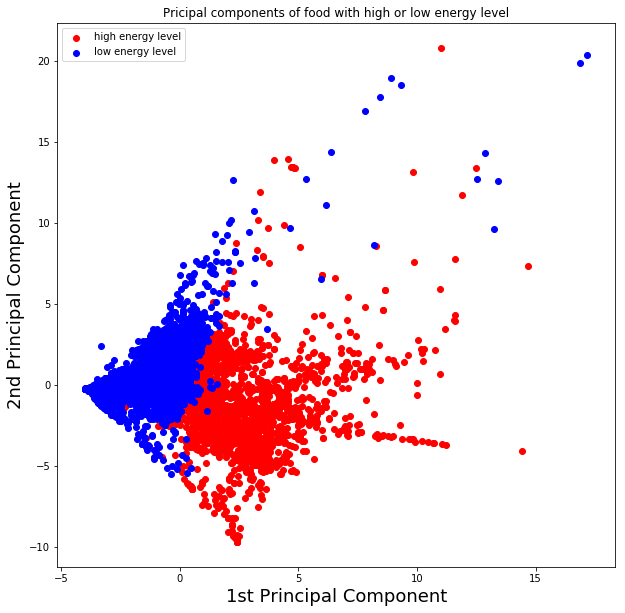

In [183]:
#Question 2
###2a
#get a new column with boolean value depends on if energy is larger than 1000kJ
foodenergy=food["Energy, with dietary fibre (kJ)"]>1000    
foodscalednew=foodscaled.copy()
foodscalednew['Energylevel']=foodenergy.astype(int)         #transfer boolean type in to 0 and 1

###2b
#find the variance
sklearn_pca = sklearnPCA(n_components=2)   #find the first two principal components
foodreduced = sklearn_pca.fit_transform(foodscalednew) #fit in the data in foodreduced
###2c
foodscalednew['pc1']=foodreduced[:,0]
foodscalednew['pc2']=foodreduced[:,1]
plot1st1=foodscalednew['pc1'].loc[foodscalednew['Energylevel']==1]   #find the sugar with high energy level
plot1st0=foodscalednew['pc1'].loc[foodscalednew['Energylevel']==0]   #find the sugar with low energy level
plot2nd1=foodscalednew['pc2'].loc[foodscalednew['Energylevel']==1]      #find the protein with high energy level
plot2nd0=foodscalednew['pc2'].loc[foodscalednew['Energylevel']==0]      #find the protein with low energy level

plt.figure(figsize=(10,10))
plt.scatter(plot1st1, plot2nd1,c= 'r')     #plot high energy level food
plt.scatter(plot1st0, plot2nd0,c= 'b')     #plot low energy level food
#set up the colour scheme where high energy is red and low energy is blue

plt.xlabel('1st Principal Component', fontsize=18)            #label x axis first principal component
plt.ylabel('2nd Principal Component', fontsize=18)            #label y axis second principal component
plt.title("Pricipal components of food with high or low energy level")
plt.legend(["high energy level", "low energy level"])    #add legend
plt.show()




Question 2d 
It is clustered into two distinguishable sets with different color, blue(low energy level) on the left and red(high energy level) on the right. This suggests the low energy food and high energy foods has differing 1st principle components against each other. High energy foods generally has larger 1st pricipal component than low energy foods. However, energy level of food can not be distinguished by different 2nd principal component value. This suggests 1st principal component retains more information with energy level. 

The advantage of using PCA is that it can reduce several features with linear relationship into one principal component; it is much easier for human to see the pattern of data after dimension reduction.    

The disadvantage of using PCA is that it cannot demonstrate nonlinear relation between features; dimension reducing will ultimately erase the nonlinear relation between different features.

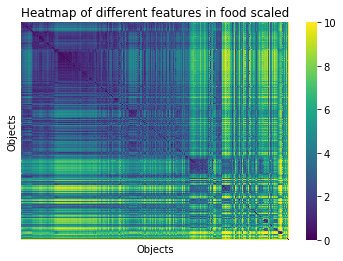

In [184]:
#Question 3
###3a
Survey_ID=food['Survey ID']                    #find the serie of Survey ID in food 
Survey_ID = Survey_ID.astype(str)              #convert datatype into string
foodscaled['Food category']= Survey_ID.str.slice(stop=2)    #get the new dataframe with food category as header

###3b
food13=foodscaled.loc[foodscaled["Food category"]=="13"]      #filter the food with food category 13
food20=foodscaled.loc[foodscaled["Food category"]=="20"]      #filter the food with food category 13
food24=foodscaled.loc[foodscaled["Food category"]=="24"]      #filter the food with food category 13
foodscaleds=pd.concat([food13, food20, food24])           #combine series together as a dataframe
foodscaledsample=foodscaleds.drop(columns=["Food category"])
###3c
#Apply VAT Algorithm to the dataset 
RV, C, I = VAT(foodscaledsample)

###3d
x=sns.heatmap(RV,cmap='viridis',vmax=10,xticklabels=False,yticklabels=False)  #visualise the dataframe using heatmap
x.set(xlabel='Objects', ylabel='Objects')                       #set x axis and y axis
plt.title("Heatmap of different features in food scaled")
plt.show()


Question 3e here
There are 2 clusters shown in the heatmap. As we selected 3 food categories of foods, three clusters should be expected, representing three different food categories.However, the diagram shows there are only two clusters, indicating that there are two catagories of foods very simular to each other; one cluster is isolated from the others. With the use of different colormaps, the pattern of cluster can be revealed more clearly with the use of contrasting color. An optimal colormap is able demonstrate different clusters clearly with strong contrast in color map.

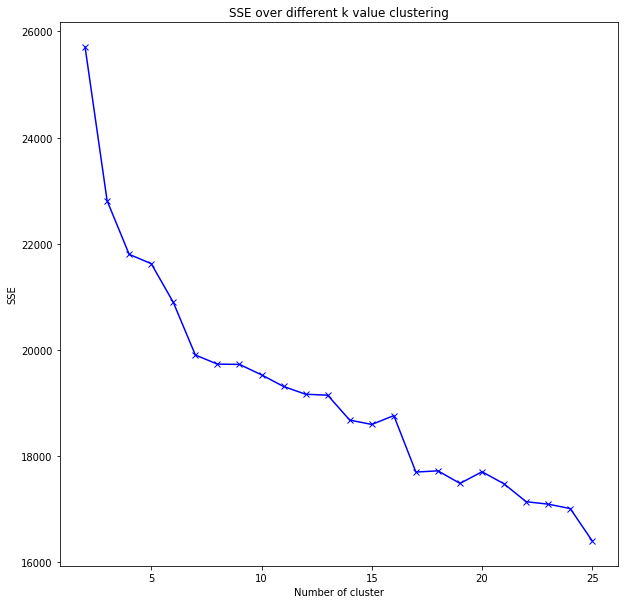

In [185]:
#Question 4
###4a 
fooddata=foodscaled.drop(columns=["Food category"]).values   #find the values of dataframe
sse = {}                     #generate an empty dictionary to store different value of kmean and corresponding SSE
#loop around k values in range 2, 3, 4 ... 25
for k in range(2, 26):
    kmeans = KMeans(n_clusters=k, random_state=100).fit(fooddata)  #find kmeans of the fooddata
    #store its sum of squared error in dictionary, select least squared error representing data is in the cluster
    sse[k] =sum(np.min(cdist(foodscaled.drop(columns=["Food category"]), kmeans.cluster_centers_ ,"euclidean"),axis=1))
plt.figure(figsize=(10,10))      # set the plot size
plt.plot(list(sse.keys()), list(sse.values()), "bx-")  #plot the feature
plt.xlabel("Number of cluster")                        #label x axis
plt.ylabel("SSE")                                      #label y axis
plt.title("SSE over different k value clustering")     #set title
plt.show()


Question 4b 
Due to the diagram, there is an elbow around k = 7. As food can be categorised into different food catagory, there should be 23 cluster of the dataset as the food in data sets have 23 food category. Theoretically, SSE would decrease sharply before k = 23, as each increment of k could break a large joint cluster into small cohesive clusters. And an elbow point would be expected at k = 23, as the further division of small isolated clusters cannot decrease SSE a lot. Therefore, it is not expected to see an elbow point at k = 7. The elbow point in diagram shows the optimal clustering of foods are 7 big categories. Maybe there are some catagories of food very simular to each other; they can be clustered into one cluster.

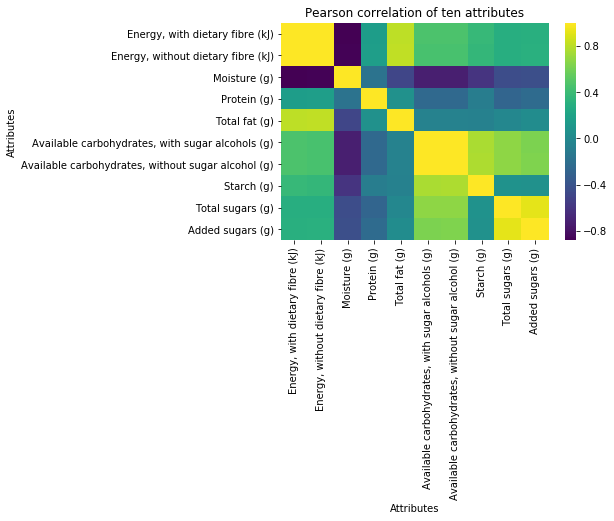

In [186]:
###Question 5

###5a
#find the features used in the data set
attributes=['Energy, with dietary fibre (kJ)', 'Energy, without dietary fibre (kJ)', 'Moisture (g)', 'Protein (g)', 'Total fat (g)', 
              'Available carbohydrates, with sugar alcohols (g)', 'Available carbohydrates, without sugar alcohol (g)', 'Starch (g)', 
              'Total sugars (g)', 'Added sugars (g)']
features=food[attributes]                                        #find the range of attributes used
correlation=features.corr()                                      #find the correlation of the dataset
x=sns.heatmap(correlation,cmap='viridis',xticklabels=attributes,yticklabels=attributes)  #visualise the heatmap
x.set(xlabel="Attributes", ylabel='Attributes')            #label x and y axis
plt.title("Pearson correlation of ten attributes")         #create title
plt.show()

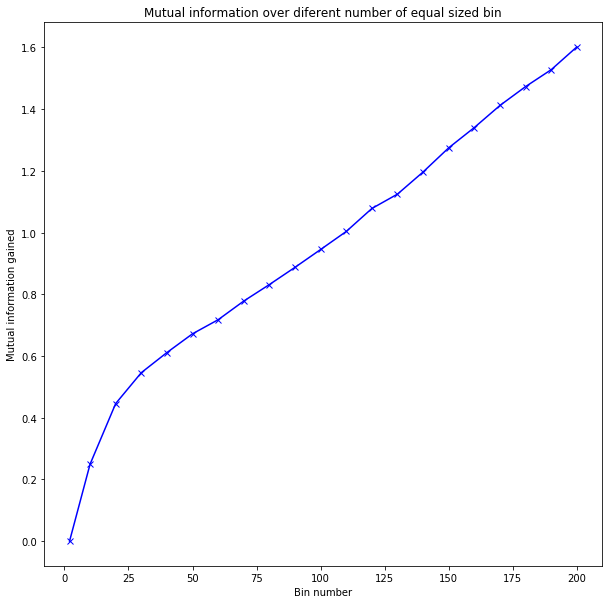

In [187]:
###5b code
binnum=[2, 10, 20, 30, 40, 50, 60, 70, 80 ,90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
MI=[]      #create an empty list to record Mutual Information
for i in binnum:
    clustered=pd.cut(food['Protein (g)'], i)                     #cluster protein into different bins
    clustered2=pd.cut(food['Energy, with dietary fibre (kJ)'], i) #cluster energy into different bins
    c=clustered.to_frame().join(clustered2.to_frame())        #find the new joined dataframe
    f=mutual_info(c)                           #compute the mutual information by equal width bin
    MI.append(f["MI"])                         # record the MI in list
plt.figure(figsize=(10,10))
plt.plot(binnum,MI,"bx-")                            #plot the MI verse different bin numbers
plt.xlabel("Bin number")                       #label x axis
plt.ylabel("Mutual information gained")        #label y axis
plt.title("Mutual information over diferent number of equal sized bin")  #create title
plt.show()


Question 5b At first, mutual information rumps up very fast, suggesting there are massive gaining of mutual information through increasing the bin number. However after bin number exceeds 20, it grows slower, suggesting there isn't too much extra information derived from using of more bins; those further increasing of bin number are not effective. 

In [188]:
###5c code
listcorr={} #create list to record the correlation between two attributes
listMI={}   #create list to record the mutual information between two attributes
featureshape=np.shape(foodscaled.drop(columns=['Food category']))
featurenum=featureshape[1]
for i in range(featurenum-1):
    features1=foodscaled.iloc[:,i]  #find the ith feature
    for j in range((i+1),featurenum):
        features2=foodscaled.iloc[:,j]        #find jth feature
        key=(i,j)                          #set the key 
        #find correlation
        pc=features1.corr(features2, method="pearson")      
        listcorr[key]=abs(pc)                  #we only care the magnitude of correlation(absolute value), regardless of positive or negative
        #find Mutual Information
        clustered=pd.cut(features1, 20)        #cut ith feature into 20 bin
        clustered2=pd.cut(features2, 20)       #cut jth feature into 20 bin
        f=mutual_info(clustered.to_frame().join(clustered2))   #find the mutual information
        listMI[key]=f["MI"]
#Display top10correlation
print("\nTop 10 Correlation")
names=list(newfood.columns.values)   #find the list of names of all attributes
count=1                             #initialise the count of top correlation features
#find ten largest correlation attributes pairs
for name, score in nlargest(10, listcorr.items(), key=itemgetter(1)):
    l=names[name[0]]         #find name of first feature
    k=names[name[1]]         #find name of second feature
    print (count, l," --- ", k, score)   #display the result
    count+=1
    
#Display top10MI
print("\nTop 10 Mutual Information")
count = 1                 #initialise the count of top MI features
names=list(newfood.columns.values)
#find ten largest MI attributes pairs
for name, score in nlargest(10, listMI.items(), key=itemgetter(1)):
    l=names[name[0]]         #find name of first feature
    k=names[name[1]]         #find name of second feature
    print (count, l," --- ", k, score)  #display the result
    count+=1



Top 10 Correlation
1 Alpha-tocopherol (mg)  ---  Vitamin E (mg) 0.9995279460538302
2 Energy, with dietary fibre (kJ)  ---  Energy, without dietary fibre (kJ) 0.9986075155566123
3 Beta-carotene (µg)  ---  Provitamin A (b-carotene equivalents) (µg) 0.9959606732978734
4 Available carbohydrates, with sugar alcohols (g)  ---  Available carbohydrates, without sugar alcohol (g) 0.9954656008632886
5 Added sugars (g)  ---  Free sugars (g) 0.988893682021527
6 Total Folates  (µg)  ---  Dietary folate equivalents  (µg) 0.9857627461733908
7 Total polyunsaturated fat (g)  ---  Linoleic acid (g) 0.9736404502944603
8 Folic acid  (µg)  ---  Dietary folate equivalents  (µg) 0.9581122318743727
9 Preformed vitamin A (retinol) (µg)  ---  Vitamin A retinol equivalents (µg) 0.9540996784996365
10 C22:6w3 Docosahexaenoic (mg)  ---  Total long chain omega 3 fatty acids (mg) 0.9527615965033779

Top 10 Mutual Information
1 Energy, with dietary fibre (kJ)  ---  Energy, without dietary fibre (kJ) 3.140250366319616

Question 5 c 
Simularity: There is three feature pairs have both large magnitude of correlation as well as have large mutual information. This demonstrates the corralated pair would usually have high mutual information as well.

Difference: The rest of feature pairs are all different, suggesting it is not inevitable that a feature pair with high corellation would attain high MI as well. Lots of feature pairs have very strong correlation, but their mutual information is not very high. Onthe other hand, there are many feature pairs have large mutual information, but their correlation is not very strong. 

***
Q6.a: Train Test Split Results
X_train matrix: (4592, 53)
y_train labels: (4592, 1)
X_test matrix: (1148, 53)
y_test labels: (1148, 1)
***


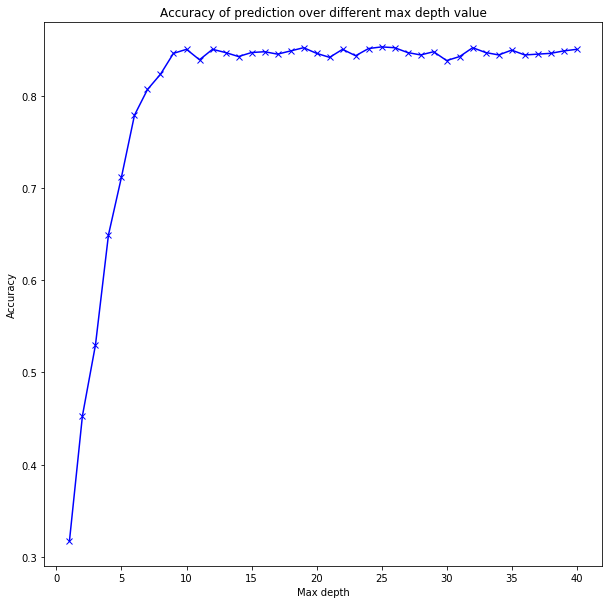

In [189]:
##Question 6
print('***')
###6a
X=foodscaled.iloc[:, :featurenum]  # find the features matrix
y=foodscaled['Food category']                               # find the corresponding label

#Split the data set into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print('Q6.a: Train Test Split Results')
print('X_train matrix:', np.shape(X_train))              #display shape of  training data
print('y_train labels:', np.shape(y_train.to_frame()))  #display shape of  training label
print('X_test matrix:', np.shape(X_test))               #display shape of  testing data
print('y_test labels:', np.shape(y_test.to_frame()))    #display shape of  testing label
print('***')

###6b
max_depth=[i for i in range(1,41)]  #find the list of max depth being tested
accuracy=[]                         #create an empty list to store corresponding accuracy
for i in max_depth:
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=i)  #build a Decision Tree Classifier
    clf = clf.fit(X_train, y_train)                  #build a model by fitting in the training data set
    labels_test = clf.predict(X_test)                #use the model to predict the test set's labels
    acc = accuracy_score(labels_test, y_test)        #find accuracy score of the model
    accuracy.append(acc)                            #record the accuracy into list

plt.figure(figsize=(10,10))                              
plt.plot(max_depth, accuracy, "bx-")                       #plot the accuracy
plt.title("Accuracy of prediction over different max depth value")  #create title
plt.xlabel("Max depth")                       #set x label
plt.ylabel("Accuracy")                        #set y label
plt.show()

Question 6c 
From the graph, it is revealed that decision tree is becoming more and more accurate before max depth approaches 10. At these stages, the further split of decision tree would divide large mixed dataset into different classes, which would decrease the entropy of dataset afterwards. So the prediction would be more and more accurate as a data can be labelled in more detailed class. After max depth exceeds 10, the accuracy stops increasing. Finally, accuracy cannot exceed 0.9 through the increasing of max depth. Because the data has already been grouped into small classes.

There are several local peaks occuring. Maybe in these times decision tree of the spliting data set, giving more accurate result of prediction.

In [190]:
#Question 7
print('***')
###7a
neigh = KNeighborsClassifier(n_neighbors=1)   #build neighbor classifier with 1 nearest neighbor
neigh.fit(X_train, y_train)                   #build model by fit the data into neighbor classifier
test = neigh.predict(X_test)                  #use the model to predict the label of test
train=neigh.predict(X_train)                  #use the model to predict the label of train        
acc = accuracy_score(test, y_test)            #find the accuracy of test
acc2 = accuracy_score(train, y_train)         #find the accuracy of the train
print('Q7a: Food category prediction using k-NN (k=1)')
print('Train accuracy:',round(acc2*100, 1), '%')     #display accuracy of training set
print('Test accuracy:', round(acc*100, 1), '%')      #display accuracy of testing set
print('***')

##7b
print('***')
neigh = KNeighborsClassifier(n_neighbors=3)   #build neighbor classifier with 3 nearest neighbor
neigh.fit(X_train, y_train)            #build model by fit in data
test = neigh.predict(X_test)           #use the model to predict the label of test
train=neigh.predict(X_train)          #use the model to predict the label of train
acc2 = accuracy_score(train, y_train)  #find the accuracy of train
acc = accuracy_score(test, y_test)    #find the accuracy of test
print('Q7.b: Food category prediction using k-NN (k=3)')
print('Train accuracy:',round(acc2*100, 1), '%')     #display accuracy of training set 
print('Test accuracy:',round(acc*100, 1),'%')        #display accuracy of testing set
print('***')




***
Q7a: Food category prediction using k-NN (k=1)
Train accuracy: 100.0 %
Test accuracy: 89.5 %
***
***
Q7.b: Food category prediction using k-NN (k=3)
Train accuracy: 93.3 %
Test accuracy: 88.0 %
***


Question 7c 
Differneces: 
1 Test accuracy values are different. Because increasing k value from 1 to 3 would make it less accurate in classifying points on boarder lines, result in the drop of the total testing accuracy.
2 Training accuracy is 100 % when k=1, but became less than 1 for k = 3. Because when k is no longer than 1, there could be some error occurs when classifying points located around the boarder line. By priciple of majority vote, the point would not be classified to the nearest point if the other two nearing points are in the other class.
Similarity : 
1 Both training accuracies are larger than the test accuracy. Because the model is built upon the training set, it would be very accurate in predicting the known dataset itself again. But, for testing new data, it would be less accurate as the model is a general estimation with assumptions that element from same class would have simular feature.
2 Both test accuracies are relatively big (>0.5), indicating the model is useful in predicting class. 

Question 7d 
We normalised the data first before split, which could result in over optimistic estimation of the model.Theoretically, we don't know any information of testing data while building the model. But the scaling process of the traing data is based on the whole data set, combined with testing data initially. So that the result of test set may be more accuracte in testing this data set. If we use the model to test another set of random data, the accuracy would drop if there are some unforeseen outliners.


In [76]:
#Question 8 code
#feature generation
#method 1 interaction pairs
foodscaled1=foodscaled.copy()           #make a copy of foodscaled to test the second method
foodscaled2=foodscaled.copy()           #make a copy of foodscaled to test the third method
y=foodscaled['Food category']      #label is food category
accuracy=[]

for i in range(0,featurenum-1):
    f1 = foodscaled.iloc[:,i]                  #select a feature
    for j in range(i+1,featurenum):
        foodscaledp=foodscaled.copy()           #make a copy of foodscaled to test the fpair method
        f2 = foodscaled.iloc[:,j]                  # select anothor feature
        #Those two features seems relevant to fat in a food, a new feature is generated as proportion of monounsaturated fat among all fats
        fpair=f1*f2    
        foodscaled=pd.concat([foodscaledp,fpair], axis=1)
        #join the feature inside the data frame to create a new dataframe
        #build and test the model
        #Split data into 80% training set and 20% testing set
        X_train, X_test, y_train, y_test = train_test_split(foodscaled.drop(columns=['Food category']), y, random_state=42, test_size=0.2)
        neigh = KNeighborsClassifier(n_neighbors=1)   #build neighbor classifier with k nearest neighbor
        neigh.fit(X_train, y_train)                   #build model by fit the data into neighbor classifier
        test = neigh.predict(X_test)           #use the model to predict the label of test
        acc = accuracy_score(test, y_test)     #find the accuracy of test
        accuracy.append(acc)

#Plot the accuracy of model over different numbers of new features generated
plt.plot(accuracy,"bx-")       
plt.title('Accuracy of kNN model over different number of new fpairs')  #set title
plt.xlabel('Number of new fpair')  #set x label
plt.ylabel('Accuracy')             # set y label
plt.show()


KeyboardInterrupt: 

As shown in plot, the accuracy value of new model does not generally increase a lot while adding a new fpair. There are only feew fpair insertion booms the accuracy, the majority accuracy remains around 0.9. As shown in my method above, creating new features randomly by combining feature pairs is not an effective way in booming accuracy. The greatest challenge is to find out the key features that can boom the accuracy of model.

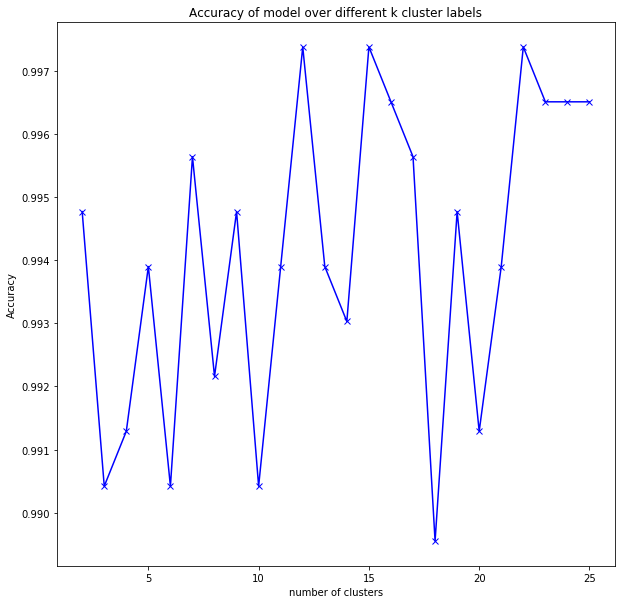

In [191]:
#method 2 clustering labels
clusteraccuracy=[]                #make an empty list to record accuracy
kvalues=[i for i in range(2,26)]  #find a list of k values
for k in kvalues:   
    kmeansfood = KMeans(n_clusters=k, random_state=100).fit(foodscaled1.drop(columns=['Food category']))
    label=kmeansfood.labels_                                 #find label of each food from kmeans
    #add the new fcluster into the data frame to build a new model
    fclusterlabel=pd.Series(label.tolist())                  
    foodscaledk = foodscaled1.join(fclusterlabel.to_frame())
    #build and test the model
    #Split data into 80% training set and 20% testing set
    X_train, X_test, y_train, y_test = train_test_split(foodscaledk.drop(columns=['Food category']), fclusterlabel, random_state=42, test_size=0.2)
    neigh = KNeighborsClassifier(n_neighbors=1)   #build neighbor classifier with k nearest neighbor
    neigh.fit(X_train, y_train)                   #build model by fit the data into neighbor classifier
    test = neigh.predict(X_test)                  #use the model to predict the label of test
    acc = accuracy_score(test, y_test)            #find the accuracy of test
    clusteraccuracy.append(acc)
    clusterfeature[k]=acc

plt.figure(figsize=(10, 10))         #set the plot size
plt.plot(kvalues, clusteraccuracy, "bx-")   #plot the accuracy of cluster over different 
plt.title("Accuracy of model over different k cluster labels")    #set title
plt.xlabel("number of clusters")                   #set x label
plt.ylabel("Accuracy")                            #set y label
plt.show()



As shown in plot, the accuracy value of new model has been greatly increased after adding the new feature fcluster. These accuracies are almost equal to 1 for all different k values implemented above. Creating new features by combining feature pairs is a very good way in booming accuracy of the model. This is because the kmeans can give an additional class label of the dataset, this label is very simular to the food category label, giving large amount of information of food category. So that the prediction of the model would be very accurate.

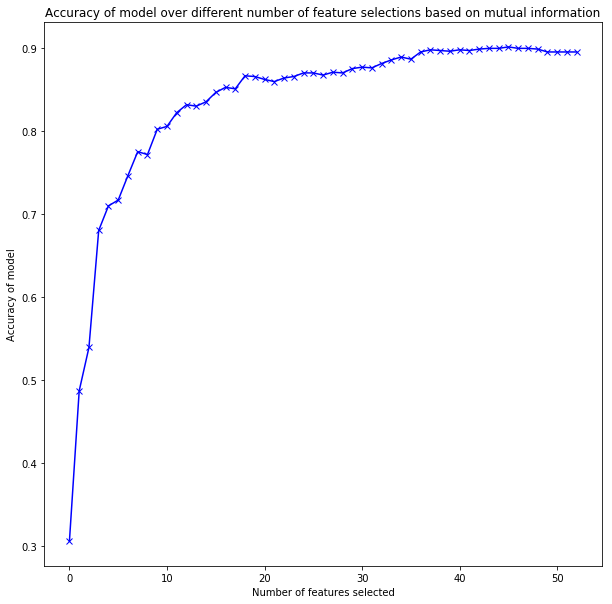

In [192]:
#Use mutual information to select features
#create an empty list to store index of the selected feature  
MIfeature={}
y=foodscaled2['Food category']      #label is food category
#find the pair of feature with largest MI
for i in range(featurenum):
    clustered=pd.cut(foodscaled2.iloc[:,i], 20)                     #cluster protein into different bins
    clustered2=pd.cut(y.astype(int), 20) #cluster energy into different bins
    c=clustered.to_frame().join(clustered2.to_frame())        #find the new joined dataframe
    f=mutual_info(c)                           #compute the mutual information by equal width bin
    MIfeature[i]=f["MI"]
    
selectaccuracy=[]  #make an empty list to record accuracy of model by different feature selection
for n in range(1,featurenum+1):
    newfood=pd.DataFrame()   # make an empty data frame to store new columns
    for name, score in nlargest(n, MIfeature.items(), key=itemgetter(1)):
        l=names[name]
        newfood=pd.concat([newfood, foodscaled2[l]], axis=1)
    #build and test the model
    #Split data into 80% training set and 20% testing set
    X_train, X_test, y_train, y_test = train_test_split(newfood, y, random_state=42, test_size=0.2)
    neigh = KNeighborsClassifier(n_neighbors=1)   #build neighbor classifier with k nearest neighbor
    neigh.fit(X_train, y_train)                   #build model by fit the data into neighbor classifier
    test = neigh.predict(X_test)                  #use the model to predict the label of test
    acc = accuracy_score(test, y_test)            #find the accuracy of test
    selectaccuracy.append(acc)
plt.figure(figsize=(10,10))
plt.plot(selectaccuracy,"bx-")        #plot accuracy
plt.title("Accuracy of model over different number of feature selections based on mutual information") #set title
plt.xlabel("Number of features selected")                #set x label
plt.ylabel("Accuracy of model")                          #set y label
plt.show()

As shown in the plot, at the beginning,the more features selected, the more accurate the model is. Then the accuracy stops increasing sharply when more than 20 features are selected. In the end, feature selection method cannot increase the accuracy of model further, once it 0.9. This suggests it is not a good way in booming up accuracy further. Because discarding some features can only remove some redundant features, reducing some manipulative information. But there is additional information gainned, so that the accuracy of model cannot boom up greatly.

In conclusion, the best method to boom the accuracy of model is creating new features by generating kmeans label while building the model.